# Data Science Professional Certificate - Capstone Project

This notebook will be used for the Capstone Project of IBM Data Science Professional Certificate hosted on Coursera.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder
import folium
import utils
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
plt.style.use('ggplot')

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


### Part I: Prepare Data

Prepare neighborhood data from Wikipedia: https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius.

In [35]:
wiki_tables = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius')

In [36]:
wiki_tables[0]

,Unnamed: 0,Neighborhoods,Area (km2)[1],Pop. (2001)[1],Density (2001)[1],Latitude,Longitude
0,1,Verkiai,56.0,30856,551.0,54.708707,25.284686
1,2,Antakalnis,77.2,39697,514.2,54.701126,25.308957
2,3,Pašilaičiai,7.9,25674,3249.9,54.725942,25.231328
3,4,Fabijoniškės,5.9,36644,6210.8,54.723397,25.249529
4,5,Pilaitė,13.9,15996,1150.8,54.708126,25.175803
5,6,Justiniškės,3.0,30958,10319.3,54.717905,25.220236
6,7,Viršuliškės,2.6,16250,6250.0,54.717867,25.220222
7,8,Šeškinė,4.6,36604,7957.4,54.715694,25.244574
8,9,Šnipiškės,3.1,19321,6232.6,54.692956,25.285007
9,10,Žirmūnai,5.7,47410,8317.5,54.723249,25.297213


Take the dataset and drop unnecesary columns.

In [37]:
df_wiki = wiki_tables[0].drop(columns=['Unnamed: 0', 'Pop. (2001)[1]', 'Density (2001)[1]'])

Rename remaining columns to more convenient names.

In [38]:
df_wiki.rename(columns={'Neighborhoods': 'neighborhood', 'Area (km2)[1]': 'area', 'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

Prepare real estate pricing data that was prepared manually using the following resource: https://en.aruodas.lt/kainu-statistika/.

In [39]:
df_price = pd.read_csv('../data/vilnius_real_estate_prices.csv').drop(columns='Unnamed: 4')

In [40]:
df_price.head(10)

,neighborhood,date,flat_price_per_sqm,house_price_per_sqm
0,Verkiai,2015,2438.88,962.88
1,Verkiai,2016,2188.20,1042.48
2,Verkiai,2017,2123.95,1163.34
3,Verkiai,2018,2328.84,1302.48
4,Verkiai,2019,2542.43,1234.01
5,Antakalnis,2015,1712.65,1121.87
6,Antakalnis,2016,1765.60,1258.29
7,Antakalnis,2017,1883.70,1249.95
8,Antakalnis,2018,2079.65,1309.00
9,Antakalnis,2019,2159.75,1204.06


In [41]:
df_price['date'] = df_price['date'].astype(str)

Pivoting the table to make the calculation of price increase in percentages easier.

In [42]:
df_piv = df_price.pivot(index='neighborhood', columns='date', values=['flat_price_per_sqm', 'house_price_per_sqm']).reset_index()

In [43]:
# https://stackoverflow.com/questions/27071661/pivoting-pandas-dataframe-into-prefixed-cols-not-a-multiindex
df_piv.columns = ['_'.join(col).strip() for col in df_piv.columns]

In [44]:
df_piv.rename(columns={'neighborhood_': 'neighborhood'}, inplace=True)

In [45]:
df_piv.head()

,neighborhood,flat_price_per_sqm_2015,flat_price_per_sqm_2016,flat_price_per_sqm_2017,flat_price_per_sqm_2018,flat_price_per_sqm_2019,house_price_per_sqm_2015,house_price_per_sqm_2016,house_price_per_sqm_2017,house_price_per_sqm_2018,house_price_per_sqm_2019
0,Antakalnis,1712.65,1765.60,1883.70,2079.65,2159.75,1121.87,1258.29,1249.95,1309.00,1204.06
1,Fabijoniškės,1314.05,1362.96,1418.37,1451.09,1487.74,875.79,821.89,1027.83,1189.95,1085.74
2,Grigiškės,908.17,576.28,1251.76,1455.94,1076.84,778.37,754.49,882.99,758.15,902.68
3,Justiniškės,1180.37,1254.17,1419.11,1435.46,1561.02,861.15,890.67,1114.67,1379.03,1766.02
4,Karoliniškės,1662.53,1795.17,1894.88,1756.66,2193.33,1196.78,1321.02,1387.47,1155.58,1326.13


In [46]:
def get_price_change_percentages(row, year, prev_year):
    return round((row[year] - row[prev_year]) / row[prev_year] * 100, 2)

In [47]:
for year in range(2016, 2020):
    df_piv[f'flat_perc_{year}_vs_{year-1}'] = df_piv.apply(get_price_change_percentages, args=(f'flat_price_per_sqm_{year}', f'flat_price_per_sqm_{year-1}'), axis=1)
    df_piv[f'house_perc_{year}_vs_{year-1}'] = df_piv.apply(get_price_change_percentages, args=(f'house_price_per_sqm_{year}', f'house_price_per_sqm_{year-1}'), axis=1)

In [48]:
df_piv.drop(columns=['flat_price_per_sqm_2015', 'flat_price_per_sqm_2016', 'flat_price_per_sqm_2017', 'flat_price_per_sqm_2018',
                     'house_price_per_sqm_2015', 'house_price_per_sqm_2016', 'house_price_per_sqm_2017', 'house_price_per_sqm_2018'],
            inplace=True)

In [54]:
df_piv.head()

,neighborhood,flat_price_per_sqm_2019,house_price_per_sqm_2019,flat_perc_2016_vs_2015,house_perc_2016_vs_2015,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,flat_perc_2019_vs_2018,house_perc_2019_vs_2018
0,Antakalnis,2159.75,1204.06,3.09,12.16,6.69,-0.66,10.40,4.72,3.85,-8.02
1,Fabijoniškės,1487.74,1085.74,3.72,-6.15,4.07,25.06,2.31,15.77,2.53,-8.76
2,Grigiškės,1076.84,902.68,-36.54,-3.07,117.21,17.03,16.31,-14.14,-26.04,19.06
3,Justiniškės,1561.02,1766.02,6.25,3.43,13.15,25.15,1.15,23.72,8.75,28.06
4,Karoliniškės,2193.33,1326.13,7.98,10.38,5.55,5.03,-7.29,-16.71,24.86,14.76


In [52]:
df_join = df_wiki.merge(df_piv, on='neighborhood')

In [55]:
df_join.head()

,neighborhood,area,latitude,longitude,flat_price_per_sqm_2019,house_price_per_sqm_2019,flat_perc_2016_vs_2015,house_perc_2016_vs_2015,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,flat_perc_2019_vs_2018,house_perc_2019_vs_2018
0,Verkiai,56.0,54.708707,25.284686,2542.43,1234.01,-10.28,8.27,-2.94,11.59,9.65,11.96,9.17,-5.26
1,Antakalnis,77.2,54.701126,25.308957,2159.75,1204.06,3.09,12.16,6.69,-0.66,10.40,4.72,3.85,-8.02
2,Pašilaičiai,7.9,54.725942,25.231328,1346.12,1355.49,6.19,-12.83,9.50,19.07,-4.15,23.76,3.04,7.99
3,Fabijoniškės,5.9,54.723397,25.249529,1487.74,1085.74,3.72,-6.15,4.07,25.06,2.31,15.77,2.53,-8.76
4,Pilaitė,13.9,54.708126,25.175803,1527.27,1079.82,3.01,0.70,8.35,8.53,-1.76,6.80,4.42,4.43


### Part II: Extract Foursquare Data

Coordinates of Vilnius (got them manually by doing a Google search):

In [58]:
vilnius_lat = 54.6872
vilnius_lng = 25.2797

Plot Vilnius map with neighborhoods.

In [64]:
map_vilnius = folium.Map(location=[vilnius_lat, vilnius_lng], zoom_start=12)

for lat, lng, neighborhood in zip(df_join['latitude'], df_join['longitude'], df_join['neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_vilnius)
    
map_vilnius

Looking at the map it's quite obvious that neighborhood coordinates are wrong. It seems that the Wikipedia page has wrong coordinates entered. We need to get more exact coordinates in a different way.

In [78]:
g = geocoder.google('Verkiai, Vilnius, Lithuania')
g

<[REQUEST_DENIED] Google - Geocode [empty]>

In [ ]:
for index, row in df.iterrows():
    lat_lng_coords = None
    neighborhood = row['neighborhood']
    
    while lat_lng_coords is None:
        g = geocoder.google(f'{neighborhood}, Vilnius, Lithuania')
        lat_lng_coords = g.latlng
        
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    df.loc[index, 'latitude'] = latitude
    df.loc[index, 'longitude'] = longitude
    
    if (index % 9) == 0:
        print('10 rows processed')

Get Toronto venues for each neighborhood using the Foursquare API. See the function in utils.py for details.

In [26]:
# Add Foursquare API key, secret and version to utils.py for this to work
toronto_venues = utils.get_nearby_venues(names=df_tor['Neighbourhood'],
                                         latitudes=df_tor['Latitude'],
                                         longitudes=df_tor['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [27]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [28]:
toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            1192 non-null   object 
 1   Neighborhood Latitude   1192 non-null   float64
 2   Neighborhood Longitude  1192 non-null   float64
 3   Venue                   1192 non-null   object 
 4   Venue Latitude          1192 non-null   float64
 5   Venue Longitude         1192 non-null   float64
 6   Venue Category          1192 non-null   object 
dtypes: float64(4), object(3)
memory usage: 65.3+ KB


Perform one-hot-encoding by venue category. This is to be used for clustering later on.

In [29]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# Move neighborhood column to the first column
neighborhood = toronto_onehot['Neighborhood']
toronto_onehot.drop(columns='Neighborhood', inplace=True)
toronto_onehot.insert(0, 'Neighborhood', neighborhood)

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
toronto_onehot.shape

(1192, 210)

Get the mean of each venue category per neighborhood.

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [32]:
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.043478
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000


Take top 10 venue categories for each neighborhood and sort by mean. See the function in utils.py for additional details.

In [33]:
toronto_venues_sorted = utils.sort_neighborhood_venues(toronto_grouped)

In [34]:
toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Café,Hotel,Seafood Restaurant,Coffee Shop,Gastropub,American Restaurant,Pizza Place,Asian Restaurant,Jazz Club
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Steakhouse,Beer Bar,Farmers Market,Bakery,Cheese Shop,Café,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Yoga Studio,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Stadium
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Plane,Coffee Shop,Sculpture Garden,Boat or Ferry,Bar


Perform clustering on the neighborhoods. First, identify the number of clusters to be used with the elbow method.

In [35]:
X = toronto_grouped.drop(columns=['Neighborhood'])

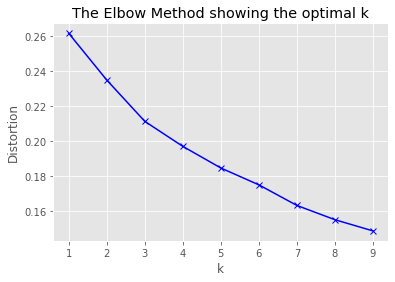

In [36]:
# Drawing inspiration from https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=50).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method is not obvious here at all. There seems to be slight changes to slope starting with 3 clusters, so let's use that. That's also a decent number of clusters to analyze manually later on.

In [37]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, n_init=50, random_state=42)
kmeans = kmeans.fit(X)

In [38]:
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [39]:
toronto_merged = df_tor.merge(toronto_venues_sorted, left_on='Neighbourhood', right_on='Neighborhood').drop(columns='Neighbourhood')

In [40]:
toronto_merged.head()

,Postcode,Borough,Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,43.676357,-79.293031,1,The Beaches,Park,Trail,Health Food Store,Pub,Yoga Studio,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant,Dog Run
1,M4K,East Toronto,43.679557,-79.352188,0,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Fruit & Vegetable Store,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,43.668999,-79.315572,0,"The Beaches West, India Bazaar",Park,Liquor Store,Movie Theater,Ice Cream Shop,Sushi Restaurant,Fish & Chips Shop,Brewery,Pub,Italian Restaurant,Fast Food Restaurant
3,M4M,East Toronto,43.659526,-79.340923,0,Studio District,Café,Coffee Shop,Brewery,Bakery,Italian Restaurant,American Restaurant,Gastropub,Park,Sandwich Place,Cheese Shop
4,M4N,Central Toronto,43.728020,-79.388790,1,Lawrence Park,Photography Studio,Park,Swim School,Bus Line,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant,Dog Run


Plot neighborhoods colored by the corresponding cluster they were assigned to.

In [41]:
map_clusters = folium.Map(location=[toronto_lat, toronto_lng], zoom_start=12)

colors = ['darkred', 'green', 'darkblue']

for lat, lon, neighborhood, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=colors[cluster],
    fill=True,
    fill_color=colors[cluster],
    fill_opacity=0.7).add_to(map_clusters)
    
map_clusters